### 💪 Analyzing Olympic data in Postgres SQL 🥇🥈🥉

The dataset for this notebook is from kaggle, 120 years of Olympic history: athletes and results [link](https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results). <br>
With the data, I will be using SQL commands to do some analysis with this notebook.

In [1]:
## Below is the DLL command to create the table schema:

DLL= """
    DROP TABLE IF EXISTS OLYMPICS_HISTORY;
CREATE TABLE IF NOT EXISTS OLYMPICS_HISTORY
(
    id          INT,
    name        VARCHAR,
    sex         VARCHAR,
    age         VARCHAR,
    height      VARCHAR,
    weight      VARCHAR,
    team        VARCHAR,
    noc         VARCHAR,
    games       VARCHAR,
    year        INT,
    season      VARCHAR,
    city        VARCHAR,
    sport       VARCHAR,
    event       VARCHAR,
    medal       VARCHAR
);

DROP TABLE IF EXISTS OLYMPICS_HISTORY_NOC_REGIONS;
CREATE TABLE IF NOT EXISTS OLYMPICS_HISTORY_NOC_REGIONS
(
    noc         VARCHAR,
    region      VARCHAR,
    notes       VARCHAR
);

select * from OLYMPICS_HISTORY;
select * from OLYMPICS_HISTORY_NOC_REGIONS;

    
    """

Once schema is created, the dataset is then uploaded with PostGresSQL. <br>
I then proceed to load the libraries to analyze with this notebook.

In [2]:
# Import creds from system directory
import sys
sys.path.append('keys')

# Import Libraries
import pandas as pd
import creds
import psycopg2

# Import Dependencies
from sqlalchemy import create_engine, text, inspect

In [3]:
# Create Database Object
host = "localhost"
database = "demo"
user = creds.user
password = creds.password
port=5432

In [4]:
### TEst

In [5]:
# Create Connection String
connection_string = f"postgresql://{user}:{password}@{host}/{database}"

In [6]:
# Create Engine
engine = create_engine(connection_string)

# Write SQL query
query = 'SELECT * from  OLYMPICS_HISTORY'

In [7]:
# Inspect Database tables available
insp = inspect(engine)
insp.get_table_names()

['olympics_history',
 'ticket_flights',
 'boarding_passes',
 'aircrafts_data',
 'flights',
 'airports_data',
 'seats',
 'tickets',
 'bookings',
 'olympics_history_noc_regions']

In [8]:
# Function to load table to df
with engine.begin() as conn:
  df = pd.read_sql_query(sql=text(query), con=conn)

In [9]:
# Print the first few rows of df
df.head()

id                      name sex age height weight            team  noc  \
0   1                 A Dijiang   M  24    180     80           China  CHN   
1   2                  A Lamusi   M  23    170     60           China  CHN   
2   3       Gunnar Nielsen Aaby   M  24     NA     NA         Denmark  DEN   
3   4      Edgar Lindenau Aabye   M  34     NA     NA  Denmark/Sweden  DEN   
4   5  Christine Jacoba Aaftink   F  21    185     82     Netherlands  NED   

         games  year  season       city          sport  \
0  1992 Summer  1992  Summer  Barcelona     Basketball   
1  2012 Summer  2012  Summer     London           Judo   
2  1920 Summer  1920  Summer  Antwerpen       Football   
3  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              event medal  
0       Basketball Men's Basketball    NA  
1      Judo Men's Extra-Lightweight    NA  
2           Football Men's Football    NA  
3       Tug-Of-War Men's Tug-Of-War  Gold  
4  Speed Skating Women's 500 metres    NA

In [10]:
# Get the shape
df.shape

(271116, 15)

### 1. Identify the sport which was played in all summer olympics.
Problem Statement: SQL query to fetch the list of all sports which have been part of every olympics.

Expected Output: Query 6


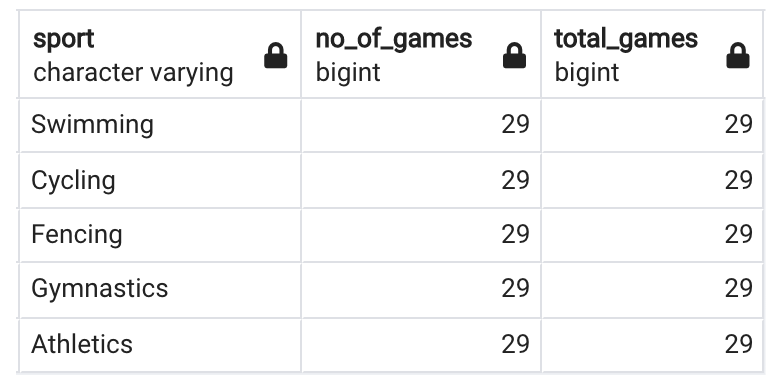

Approach:

1. Find total no of summer olympic games
2. Find for each sport, how manu games where they played in
3. Compare 1 & 2

In [11]:
# Write SQL query
query2 = ("""with t1 as
    (select count(distinct games) as total_summer_games
    from OLYMPICS_HISTORY
    where season = 'Summer'),
t2 as
    (select distinct sport, games
    from OLYMPICS_HISTORY
    where season = 'Summer' order by games),
t3 as
    (select sport, count(games) as no_of_games
    from t2
    group by sport)
select * 
from t3
join t1 on t1.total_summer_games = t3.no_of_games;
        """)

In [12]:
# Function to load table to df2
with engine.begin() as conn:
  df2 = pd.read_sql_query(sql=text(query2), con=conn)

In [13]:
# Print the output
df2.head()

sport  no_of_games  total_summer_games
0    Swimming           29                  29
1     Cycling           29                  29
2     Fencing           29                  29
3  Gymnastics           29                  29
4   Athletics           29                  29

### 2. Fetch the top 5 athletes who have won the most gold medals.
Problem Statement: SQL query to fetch the top 5 athletes who have won the most gold medals.

Expected Output: Showing few records only

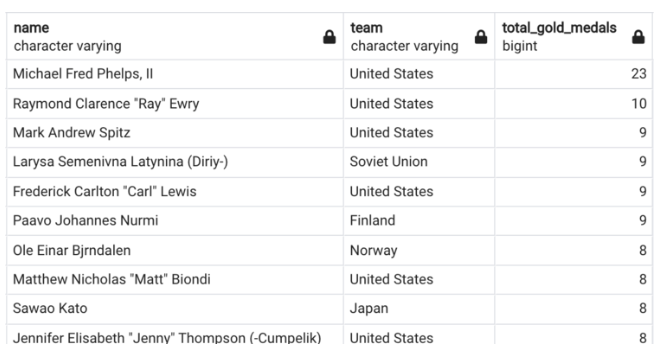

In [14]:
# Write SQL query
query3 = ("""
    with t1 as
        (SELECT name, count(1) as total_medals
        from OLYMPICS_HISTORY
        where medal = 'Gold'
        group by name
        order by count(1) desc),
        t2 as
        (SELECT *, dense_rank() over(order by total_medals desc) as rnk from t1)
        SELECT * from t2
        where rnk <=5;
          """)

In [15]:
# Function to load table
with engine.begin() as conn:
  df3 = pd.read_sql_query(sql=text(query3), con=conn)

df3.head(30)

name  total_medals  rnk
0                           Michael Fred Phelps, II            23    1
1                       Raymond Clarence "Ray" Ewry            10    2
2                Larysa Semenivna Latynina (Diriy-)             9    3
3                    Frederick Carlton "Carl" Lewis             9    3
4                              Paavo Johannes Nurmi             9    3
5                                 Mark Andrew Spitz             9    3
6                                        Sawao Kato             8    4
7                                Usain St. Leo Bolt             8    4
8                               Ole Einar Bjrndalen             8    4
9                    Matthew Nicholas "Matt" Biondi             8    4
10                           Birgit Fischer-Schmidt             8    4
11  Jennifer Elisabeth "Jenny" Thompson (-Cumpelik)             8    4
12                          Aladr Gerevich (-Gerei)             7    5
13                      Borys Anfiyanovych Shakhlin             7    5
14                     Nikolay Yefimovich Andrianov             7    5
15                        Viktor Ivanovych Chukarin             7    5
16                  Donald Arthur "Don" Schollander             7    5
17                           Vra slavsk (-Odloilov)             7    5

### 3. List down total gold, silver and bronze medals won by each country.
Problem Statement: Problem Statement: Write a SQL query to list down the  total gold, silver and bronze medals won by each country.

Expected Output: Showing few records only

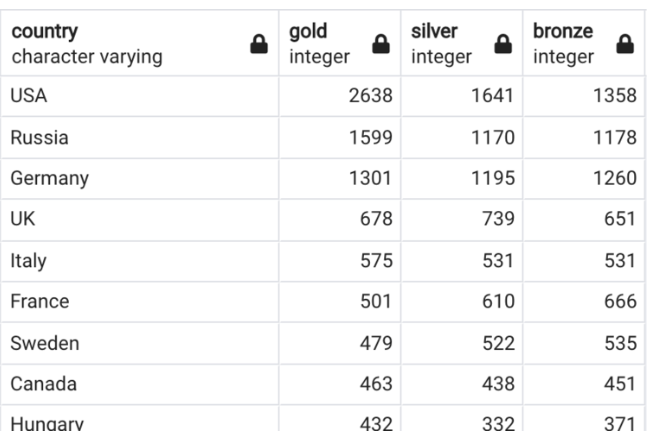

In [16]:
query4 = (""" create extension tablefunc """);

In [17]:
# Write SQL query
query4 = ("""
        SELECT nr.region as country, medal, count(1) as total_medals
            from OLYMPICS_HISTORY oh
            join OLYMPICS_HISTORY_noc_regions nr 
            on nr.noc = oh.noc
            where medal <> 'NA'
            group by nr.region, medal
            order by nr.region, medal;
        
        SELECT country
        , coalesce(gold, 0) as gold
        , coalesce(silver, 0) as silver
        , coalesce(bronze, 0) as bronze
        from crosstab('SELECT nr.region as country, medal, count(1) as total_medals
                from OLYMPICS_HISTORY oh
                join OLYMPICS_HISTORY_noc_regions nr 
                on nr.noc = oh.noc 
                where medal <> ''NA''
                group by nr.region, medal
                order by nr.region, medal',
                'values (''Bronze''), (''Gold''), (''Silver'')')
                as result(country varchar, bronze bigint, gold bigint, silver bigint)
        order by gold desc, silver desc, bronze desc;
          """)

In [18]:
# Function to load table to df4
with engine.begin() as conn:
  df4 = pd.read_sql_query(sql=text(query4), con=conn)

df4.head(10)

country  gold  silver  bronze
0      USA  2638    1641    1358
1   Russia  1599    1170    1178
2  Germany  1301    1195    1260
3       UK   678     739     651
4    Italy   575     531     531
5   France   501     610     666
6   Sweden   479     522     535
7   Canada   463     438     451
8  Hungary   432     332     371
9   Norway   378     361     294

### 4. Identify which country won the most gold, most silver and most bronze medals in each olympic games.
Problem Statement: Write SQL query to display for each Olympic Games, which country won the highest gold, silver and bronze medals.

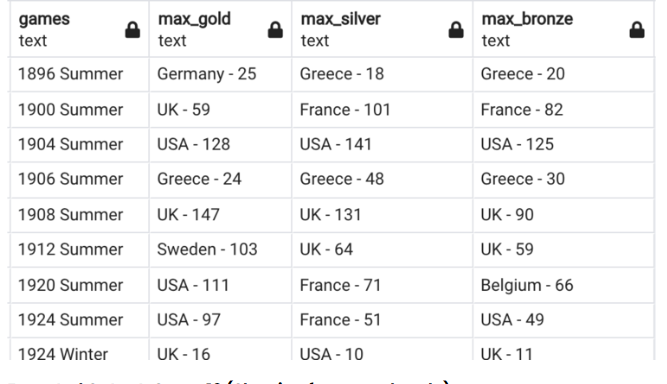

In [19]:
# Write SQL query
query5 = ("""
        SELECT nr.region as country, medal, count(1) as total_medals
            from OLYMPICS_HISTORY oh
            join OLYMPICS_HISTORY_noc_regions nr 
            on nr.noc = oh.noc
            where medal <> 'NA'
            group by nr.region, medal
            order by nr.region, medal;
            
        with temp as
            (SELECT substring(games_country, 1, position('-' in games_country) -1) as games
            , substring(games_country, position('-' in games_country) + 1) as country
            , coalesce(gold, 0) as gold
            , coalesce(silver, 0) as silver
            , coalesce(bronze, 0) as bronze
            from crosstab('SELECT concat(games, ''-'', nr.region) as games_country, medal, count(1) as total_medals
                    from OLYMPICS_HISTORY oh
                    join OLYMPICS_HISTORY_noc_regions nr 
                    on nr.noc = oh.noc 
                    where medal <> ''NA''
                    group by games, nr.region, medal
                    order by games, nr.region, medal',
                    'values (''Bronze''), (''Gold''), (''Silver'')')
                    as result(games_country varchar, bronze bigint, gold bigint, silver bigint)
            order by games_country)
            
        select distinct games
        , concat(first_value(country) over(partition by games order by gold desc)
                , '-'
                , first_value(gold) over(partition by games order by gold desc)) as gold
        , concat(first_value(country) over(partition by games order by silver desc)
                , '-'
                , first_value(silver) over(partition by games order by silver desc)) as silver
        , concat(first_value(country) over(partition by games order by bronze desc)
                , '-'
                , first_value(bronze) over(partition by games order by bronze desc)) as bronze
        from temp
        order by games;
          """)

In [20]:
# Function to load table to df5
with engine.begin() as conn:
  df5 = pd.read_sql_query(sql=text(query5), con=conn)

df5.head(10)

games        gold          silver      bronze
0  1896 Summer  Germany-25       Greece-18   Greece-20
1  1900 Summer       UK-59      France-101   France-82
2  1904 Summer     USA-128         USA-141     USA-125
3  1906 Summer   Greece-24       Greece-48   Greece-30
4  1908 Summer      UK-147          UK-131       UK-90
5  1912 Summer  Sweden-103           UK-64       UK-59
6  1920 Summer     USA-111       France-71  Belgium-66
7  1924 Summer      USA-97       France-51      USA-49
8  1924 Winter       UK-16          USA-10       UK-11
9  1928 Summer      USA-47  Netherlands-29  Germany-41

### 5. In which Sport/event, Singapore has won highest medals.
Problem Statement: Write SQL Query to return the sport which has won Singapore the highest no of medals. 

In [21]:
# Write SQL query
query6 = ("""
    with t1 as
        (select sport, count(1) as total_medals
        from olympics_history
        where medal <> 'NA'
        and team = 'Singapore'
        group by sport
        order by total_medals desc),
        t2 as
        (select *, rank() over(order by total_medals desc) as rnk
        from t1)
    select sport, total_medals
    from t2
    where rnk = 1;

          """)

In [22]:
# Function to load table to df5
with engine.begin() as conn:
  df6 = pd.read_sql_query(sql=text(query6), con=conn)

df6.head(10)

sport  total_medals
0  Table Tennis             7

In [23]:
# Write SQL query
query7 = ("""
SELECT games, sport, count(1) as total_medals 
from olympics_history
where team = 'Singapore'
and medal <> 'NA'
group by games, sport
order by total_medals desc
          """)

In [24]:
# Function to load table
with engine.begin() as conn:
  df7 = pd.read_sql_query(sql=text(query7), con=conn)

df7.head(10)

games          sport  total_medals
0  2012 Summer   Table Tennis             4
1  2008 Summer   Table Tennis             3
2  1960 Summer  Weightlifting             1
3  2016 Summer       Swimming             1

### 6. How many olympics games have been held?
Problem Statement: Write a SQL query to find the total no of Olympic Games held as per the dataset.

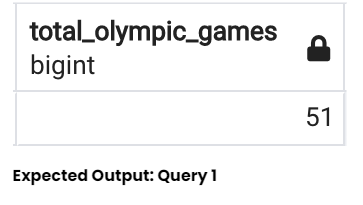

In [25]:
# Write SQL query
query8 = ("""
SELECT count(DISTINCT games) as total_olympic_games
from olympics_history
          """)

In [26]:
# Function to load table
with engine.begin() as conn:
  df8 = pd.read_sql_query(sql=text(query8), con=conn)

df8.head(10)

total_olympic_games
0                   51

### 7. List down all Olympics games held so far.

Problem Statement: Write a SQL query to list down all the Olympic Games held so far.

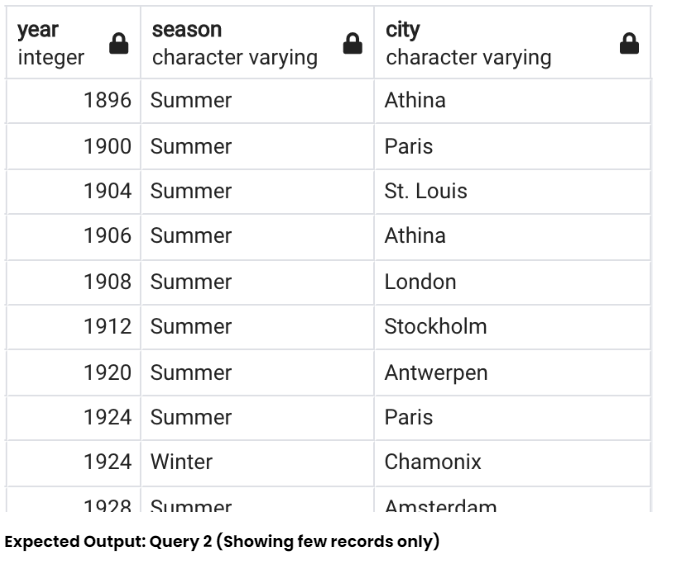

In [27]:
# Write SQL query
query9 = ("""
        SELECT year, season, city
            from OLYMPICS_HISTORY 
            GROUP BY year, season, city
            ORDER by year
          """)

# Function to load table
with engine.begin() as conn:
  df9 = pd.read_sql_query(sql=text(query9), con=conn)

df9.head(10)

year  season       city
0  1896  Summer     Athina
1  1900  Summer      Paris
2  1904  Summer  St. Louis
3  1906  Summer     Athina
4  1908  Summer     London
5  1912  Summer  Stockholm
6  1920  Summer  Antwerpen
7  1924  Summer      Paris
8  1924  Winter   Chamonix
9  1928  Summer  Amsterdam

### 8. Mention the total no of nations who participated in each olympics game?

Problem Statement: SQL query to fetch total no of countries participated in each olympic games.

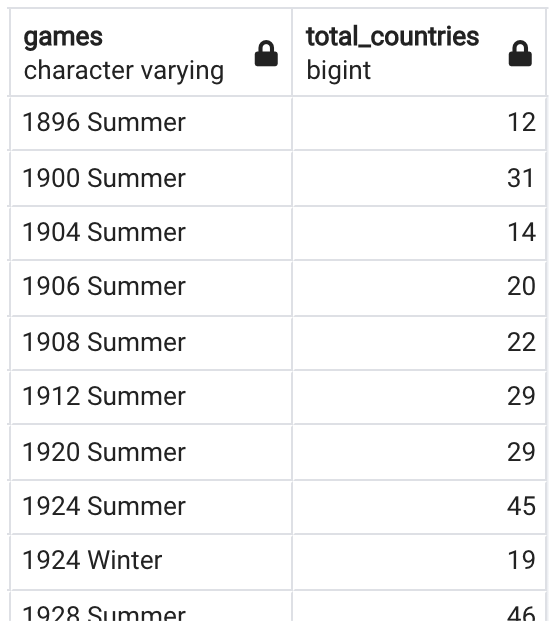

In [28]:
# Write SQL query
## Using Common Table Expressions (CTE)
query10 = (""" 
    with all_countries as
        (select games, nr.region
        from olympics_history oh
        join olympics_history_noc_regions nr ON nr.noc = oh.noc
        group by games, nr.region)
    select games, count(1) as total_countries
    from all_countries
    group by games
    order by games;

          """)

# Function to load table
with engine.begin() as conn:
  df10 = pd.read_sql_query(sql=text(query10), con=conn)

df10.head(10)

games  total_countries
0  1896 Summer               12
1  1900 Summer               31
2  1904 Summer               14
3  1906 Summer               20
4  1908 Summer               22
5  1912 Summer               29
6  1920 Summer               29
7  1924 Summer               45
8  1924 Winter               19
9  1928 Summer               46

### 9. Fetch oldest athletes to win a gold medal

Problem Statement: SQL Query to fetch the details of the oldest athletes to win a gold medal at the olympics.

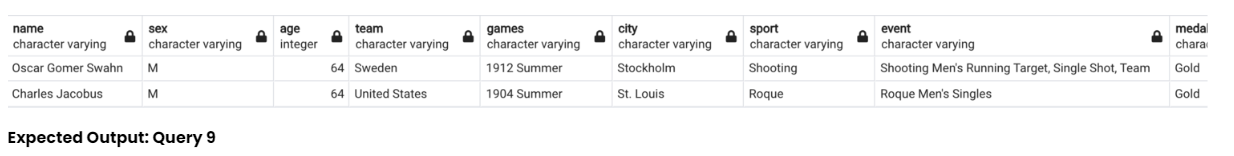

In [37]:
# Write SQL query
## Using Common Table Expressions (CTE)
query11 = (""" 
    with temp as
            (select name,sex,cast(case when age = 'NA' then '0' else age end as int) as age
              ,team,games,city,sport, event, medal
            from olympics_history),
        ranking as
            (select *, rank() over(order by age desc) as rnk
            from temp
            where medal='Gold')
    select *
    from ranking
    where rnk = 1;

          """)

# Function to load table
with engine.begin() as conn:
  df11 = pd.read_sql_query(sql=text(query11), con=conn)

df11.head(10)

name sex  age           team        games       city  \
0  Oscar Gomer Swahn   M   64         Sweden  1912 Summer  Stockholm   
1    Charles Jacobus   M   64  United States  1904 Summer  St. Louis   

      sport                                             event medal  rnk  
0  Shooting  Shooting Men's Running Target, Single Shot, Team  Gold    1  
1     Roque                               Roque Men's Singles  Gold    1

### 10. Find the Ratio of male and female athletes participated in all olympic games.

Problem Statement: Write a SQL query to get the ratio of male and female participants

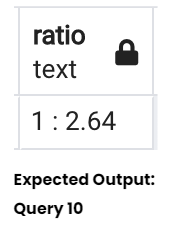

In [45]:
# Write SQL query
## Using Common Table Expressions (CTE)
query12 = (""" 
with t1 as
    (SELECT sex, count(1) as cnt
    from olympics_history group by sex),
    t2 as
        (SELECT *, row_number() over(order by cnt) as rn
        from t1),
    min_cnt as
        (select cnt from t2 
        WHERE rn = 1),
    max_cnt as
        (select cnt from t2 
        WHERE rn = 2)
        
    SELECT concat('1 : ', round(max_cnt.cnt::decimal/min_cnt.cnt, 2)) as ratio
    from min_cnt, max_cnt;
          """)

# Function to load table
with engine.begin() as conn:
  df12 = pd.read_sql_query(sql=text(query12), con=conn)

df12.head(10)

ratio
0  1 : 2.64

### 11. Fetch the top 5 athletes who have won the most medals (gold/silver/bronze).

Problem Statement: SQL Query to fetch the top 5 athletes who have won the most medals (Medals include gold, silver and bronze).

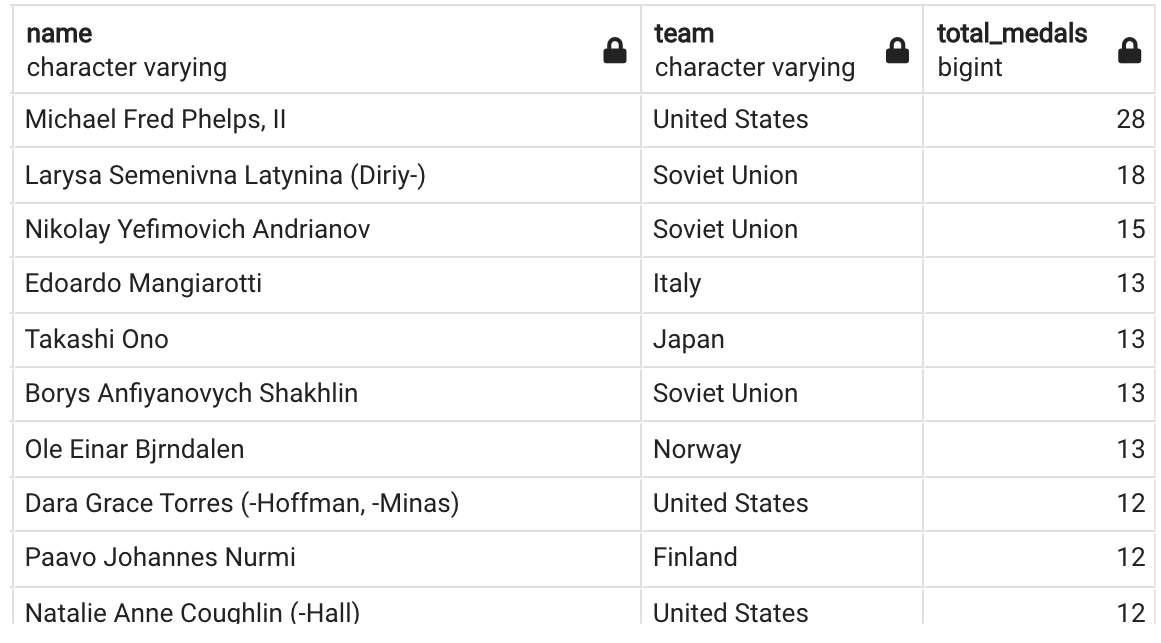

In [63]:
# Write SQL query
## Using Common Table Expressions (CTE)
query13 = (""" 
with t1 as
    (SELECT name, team, count(1) as total_medals
        from olympics_history
        where medal in ('Gold', 'Silver', 'Bronze')
        group by name, team
        order by total_medals desc),
    t2 as
        (SELECT *, dense_rank() over (order by total_medals desc) as rank
        from t1)
    SELECT name, team, total_medals 
    FROM t2
    WHERE rank <=5;
    
          """)

# Function to load table
with engine.begin() as conn:
  df13 = pd.read_sql_query(sql=text(query13), con=conn)

df13.head(10)

name           team  total_medals
0               Michael Fred Phelps, II  United States            28
1    Larysa Semenivna Latynina (Diriy-)   Soviet Union            18
2          Nikolay Yefimovich Andrianov   Soviet Union            15
3                   Edoardo Mangiarotti          Italy            13
4                           Takashi Ono          Japan            13
5           Borys Anfiyanovych Shakhlin   Soviet Union            13
6                   Ole Einar Bjrndalen         Norway            13
7  Dara Grace Torres (-Hoffman, -Minas)  United States            12
8                  Paavo Johannes Nurmi        Finland            12
9         Natalie Anne Coughlin (-Hall)  United States            12

### 12. Fetch the top 5 most successful countries in olympics. Success is defined by no of medals won.

Problem Statement: Write a SQL query to fetch the top 5 most successful countries in olympics. (Success is defined by no of medals won).

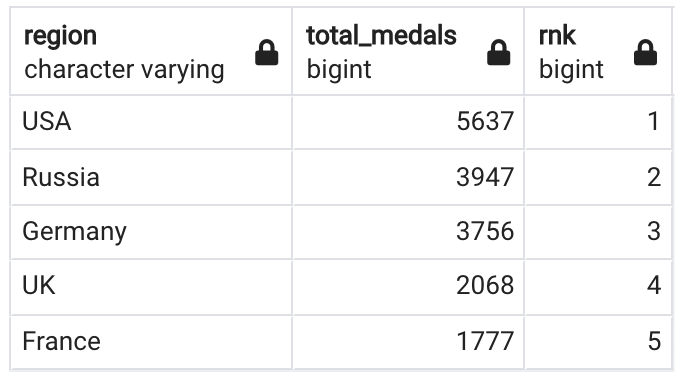

In [87]:
# Write SQL query
## Using Common Table Expressions (CTE)
query14 = (""" 
with t1 as
    (select nr.region, count(*) as total_medals
        from olympics_history oh
        join olympics_history_noc_regions nr ON nr.noc = oh.noc
        WHERE medal <> 'NA'
        group by nr.region
        ORDER BY total_medals DESC),
    t2 as
        (SELECT *, rank() over (order by total_medals desc) as rank
        from t1)
    SELECT *
    FROM t2
    WHERE rank <=5;
    
          """)

# Function to load table
with engine.begin() as conn:
  df14 = pd.read_sql_query(sql=text(query14), con=conn)

df14.head(10)

region  total_medals  rank
0      USA          5637     1
1   Russia          3947     2
2  Germany          3756     3
3       UK          2068     4
4   France          1777     5